# **PREDIZIONE DI HOTEL-ID PER LA PREVENZIONE DEL TRAFFICO DI UMANI (FGVC9 2022) - Notebook di training**

**Deep Learning 2022/2023**

**Michele Ferro 1000037665**


# 0 - Split del training set fornito da Kaggle

Il dataset utilizzato per l'esecuzione di questo progetto è stato fornito da Kaggle per la risoluzione della competition [*Hotel-ID to Combat Human Trafficking 2022 - FGVC9*](https://www.kaggle.com/competitions/hotel-id-to-combat-human-trafficking-2022-fgvc9/data).

Tale dataset, consiste semplicemente in un set di training `train_images` ed una directory `train_masks` di maschere di occlusione da applicare alle immagini.

In [1]:
import os
import random
import shutil
import csv

Vista l'assenza di un set di validazione e di uno di test, viene definita la funzione `split_dataset(dataset_path)`, la quale, preso in input il path `dataset_path` del dataset opportunemente scaricato e presente su disco, genera due ulteriori cartelle `test_images` e `val_images` a partire dalla directory `train_images`. Dopo l'esecuzione, la numerosità delle tre cartelle sarà la seguente:
- `train_images` conterrà l'80% del contenuto che aveva in origine;
- `val_images` conterrà il 20% del contenuto originario di `train_images`;
- `test_images` conterrà il 20% del contenuto originario di `train_images`.

Infine, la procedura ritorna il path di ognuna delle tre directory.

In [2]:
def split_dataset(dataset_path):
    if 'test_images' not in os.listdir(dataset_path):
        os.makedirs(os.path.join(dataset_path,'test_images'))

    if 'val_images' not in os.listdir(dataset_path):
        os.makedirs(os.path.join(dataset_path,'val_images'))

    train_path = os.path.join(dataset_path,'train_images')
    test_path = os.path.join(dataset_path,'test_images')
    val_path = os.path.join(dataset_path,'val_images')

    print(train_path)
    print(test_path)
    print(val_path)

    total_files = 0
    for folder in os.listdir(train_path):
        for file in os.listdir(os.path.join(train_path,folder)):
            total_files += 1

    train_files = int(total_files * 0.80)                   # training sample has to be 80% of total dataset
    test_val_files = total_files - train_files                  # validation/testing sample has to be 20%
    
    print(total_files)
    print('train files are supposed to be', train_files)
    print('test files are supposed to be', test_val_files)

    cnt = 0
    while cnt != test_val_files:
        for folder in os.listdir(train_path):
            if (len(os.listdir(os.path.join(train_path, folder))) != 0):
                file = random.choice(os.listdir(os.path.join(train_path, folder)))
                if os.path.isfile(os.path.join(train_path,folder,file)):
                    # copies the file in test folder
                    shutil.copy(os.path.join(train_path,folder,file), os.path.join(test_path,str(cnt)+'.jpg'))

                    # creates a folder with that hotel id (if it doesn't exist) and moves the image file into it
                    if folder not in os.listdir(val_path):
                        os.makedirs(os.path.join(val_path, folder))
                    shutil.move(os.path.join(train_path,folder,file), os.path.join(val_path, folder))

                    cnt += 1
                    if cnt == test_val_files:
                        break


    for folder in os.listdir(train_path):
        if len(os.listdir(os.path.join(train_path,folder))) == 0:
            print("Directory", os.path.join(train_path,folder), "will be deleted as it's empty")
            os.rmdir(os.path.join(train_path,folder))

    return train_path, val_path, test_path

La procedura `generate_csv(train_path, test_path, val_path)` generà un file `.csv` per ognuno dei tre set, contenenti informazioni su ognuno di essi, indicizzati secondo nome del file immagine e relativa etichetta, o semplicemente nome del file immagine (per la directory relativa al set di test).

In [3]:
def generate_csv(train_path, test_path, val_path):
    header_train = ['image_id', 'hotel_id']
    
    with open(os.path.join(dataset_path,'train.csv'), 'w') as f:
        writer = csv.writer(f)
        writer.writerow(header_train)
        for hotel_id in os.listdir(train_path):
            for image_id in os.listdir(os.path.join(train_path, hotel_id)):
                writer.writerow([image_id, hotel_id])

    with open(os.path.join(dataset_path,'val.csv'), 'w') as f:
        writer = csv.writer(f)
        writer.writerow(header_train)
        for hotel_id in os.listdir(val_path):
            for image_id in os.listdir(os.path.join(val_path, hotel_id)):
                writer.writerow([image_id, hotel_id])

    with open(os.path.join(dataset_path,'test.csv'), 'w') as f:
        writer = csv.writer(f)
        writer.writerow(['image_id'])
        for image_id in os.listdir(test_path):
            writer.writerow([image_id])

Vengono quindi eseguite le procedure sopra definite.

In [ ]:
dataset_path = os.path.join('/run/media/michele/Archivio/DL_project/hotel-id-to-combat-human-trafficking-2022-fgvc9/')

train_path, val_path, test_path = split_dataset(dataset_path)
generate_csv(train_path, test_path, val_path)

La seguente cella mostra le informazioni relative alla GPU montata sulla macchina utilizzata per l'esecuzione di questo progetto, e sulla quale verranno eseguiti tutti gli addestramenti.

In [ ]:
!nvidia-smi
!nvidia-smi --query-gpu=gpu_name --format=csv

Fri Jan  6 15:42:04 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.11    Driver Version: 525.60.11    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   38C    P8    N/A /  N/A |      4MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1 - Caricamento e manipolazione del set di training e di validazione

In [1]:
import os
import albumentations as A
import albumentations.pytorch as APT
from PIL import Image

import pandas as pd
import numpy as np

/home/michele/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset_path = os.path.join('/run/media/michele/Archivio/DL_project/hotel-id-to-combat-human-trafficking-2022-fgvc9/')

train_path = os.path.join(dataset_path, 'train_images')
test_path = os.path.join(dataset_path, 'test_images')
val_path = os.path.join(dataset_path, 'val_images')

## 1.1 - Definizione delle trasformazioni

Dato un downscaling ad una dimensione $128 \times 128$ (si consideri che le fotografie contenute nel dataset sono di risoluzione variabile), vengono definite le trasformazioni `train_transform` e `val_transform` da applicare rispettivamente al set di training e al set di validazione/test.

In [3]:
IMG_SIZE = 128

occlusion_transform = A.CoarseDropout(p=1, max_holes=1, min_height=IMG_SIZE//4, max_height=IMG_SIZE//2,
                                      min_width=IMG_SIZE//4, max_width=IMG_SIZE//2, fill_value=(255, 0, 0))

# transform used for the obtained training set
train_transform = A.Compose([A.HorizontalFlip(p=0.75),
                            A.VerticalFlip(p=0.25),
                            A.ShiftScaleRotate(p=0.5),
                            A.OpticalDistortion(p=0.25),
                            A.Perspective(p=0.25),
                            A.CoarseDropout(p=0.5, min_holes=1, max_holes=6, 
                                            min_height=IMG_SIZE//16, max_height=IMG_SIZE//4,
                                            min_width=IMG_SIZE//16, max_width=IMG_SIZE//4),
                            occlusion_transform,
                            A.Resize(IMG_SIZE, IMG_SIZE),
                            A.RandomBrightnessContrast(p=0.75),
                            A.ToFloat(),
                            APT.transforms.ToTensorV2()])

# transform used for the validation/test set
val_transform = A.Compose([occlusion_transform,
                            A.Resize(IMG_SIZE, IMG_SIZE),
                            A.ToFloat(),
                            APT.transforms.ToTensorV2()])

Si noti come ambedue le trasformazioni sono anche composte da una `occlusion_transform`, la quale simula le occlusioni di forma rossa rettangolare e di dimensioni variabili fornite da Kaggle nella directory `train_masks`. Tale occlusioni, verranno applicate al dataset al fine di poter rendere i futuri modelli maggiormente robusti al noise consistente in queste occlusioni.

## 1.2 Definizione delle classi Dataset

Si anticipa che i modelli saranno:
1. un banale classificatore di immagini;
2. un modello di metric learning.

Pertanto, devono essere studiati degli opportuni oggetti Dataset da utilizzare nell'uno e nell'altro caso, e che possano quindi funzionare in maniera opportuna.

### - DATASET A SINGOLO OUTPUT

La classe `HotelDataset` definisce un banale oggetto dataset, che restituisce un elemento (in questo caso un'immagine) e l'etichetta di classe ad esso associato nel caso in cui sia di training (o di validazione), e semplicemente un'immagine nel caso in cui il dataset sia di test.

In [4]:
class HotelDataset:
    def __init__(self, data, transform=None, data_path=train_path, train_val=True):
        self.data = data
        self.transform = transform
        self.data_path = data_path
        self.train_val = train_val

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        record = self.data.iloc[idx]

        if self.train_val:
            image_path = os.path.join(self.data_path,str(record['hotel_id']),record['image_id'])
            label = record['hotel_id']
        else:
            image_path = os.path.join(self.data_path,record['image_id'])
        
        image = np.array(Image.open(image_path)).astype(np.uint8)

        if self.transform:
            transformed = self.transform(image=image)
            image = transformed['image']
        
        if self.train_val:
            return image, label
        else:
            return image

### - DATASET CON OUTPUT IN COPPIA

Dovendo essere il modello di metric learning una **rete siamese**, l'oggetto dataset da utilizzare in questo caso dovrà restituire una coppia di elementi, invece che uno solo.

La classe `PairHotelDataset` definisce un oggetto dataset che restituisce una coppia di elementi ai quali è associata un'etichetta. In particolare, tale etichetta sarà `l == 0` nel caso in cui gli elementi della coppia sono simili (ossia, appartenenti alla stessa classe), altrimenti essa sarà `l == 1`. In particolare, ad ogni elemento della coppia, sarà associato un elemento suo simile o suo dissimile con probabilità pari a $\frac{1}{2} = 0.5$. La numerosità di questo dataset sarà pari a quella di `HotelDataset`.

In [6]:
from torch.utils import data

class PairHotelDataset(data.Dataset):
    def __init__(self, data, transform=None, data_path=train_path, train_val=True):
        self.data = data
        self.transform = transform
        self.data_path = data_path
        self.train_val = train_val

        self.indices = data['hotel_id'].unique()
        self.indices = self.indices.tolist()

        self.generate_pairs()

    def generate_pairs(self):
        self.pair_labels = (np.random.rand(len(self.data))>0.5).astype(int)

        self.paired_idx = []

        for i, l in enumerate(self.pair_labels):
            c1 = self.data.loc[i]['hotel_id'].item()
            c = c1

            if l == 0:
                j = np.random.choice(os.listdir(os.path.join(self.data_path,str(c1))))
            else:
                diff_class = np.random.choice(list(set(self.indices)-{c1}))
                j = np.random.choice(os.listdir(os.path.join(self.data_path,str(diff_class))))
                c = diff_class
            self.paired_idx.append({'image_id': j, 'hotel_id': c})

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        record1 = self.data.iloc[idx]
        record2 = self.paired_idx[idx]

        if self.train_val:
            im1_path = os.path.join(self.data_path,str(record1['hotel_id']),record1['image_id'])
            im2_path = os.path.join(self.data_path,str(record2['hotel_id']),record2['image_id'])
            
            l1 = record1['hotel_id']
            l2 = record2['hotel_id']
            l = self.pair_labels[idx]
        else:
            im1_path = os.path.join(self.data_path,str(record1['image_id']))
            im2_path = os.path.join(self.data_path,str(record2['image_id']))
        
        im1 = np.array(Image.open(im1_path)).astype(np.uint8)
        im2 = np.array(Image.open(im2_path)).astype(np.uint8)

        if self.transform:
            transformed1 = self.transform(image=im1)
            im1 = transformed1['image']

            transformed2 = self.transform(image=im2)
            im2 = transformed2['image']

        return im1, im2, l, l1, l2

# 2 - Definizione del modello

Per la definizione dei modelli verrà utilizzato il modulo `pythorch_lightning`.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import pytorch_lightning as pl
import timm                                                             # used to load EfficientNet

from torch import nn
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
from torch.optim import SGD
from pytorch_lightning.loggers import TensorBoardLogger

## 2.1 EfficientNet-B0 - Classification

In [7]:
class EfficientNet(pl.LightningModule):
    def __init__(self, n_classes, lr=0.01, momentum=0.99):
        super(EfficientNet, self).__init__()
        self.save_hyperparameters()

        self.network = timm.create_model('efficientnet_b0', num_classes=n_classes, pretrained=True)

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.network(x)

        return x

    def configure_optimizers(self):
        optimizer = SGD(self.parameters(), self.hparams.lr, momentum=self.hparams.momentum)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        output = self.forward(x)
        loss = self.criterion(output, y)
        self.log('train/loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        output = self.forward(x)
        loss = self.criterion(output, y)

        acc = accuracy_score(y.cpu(), output.cpu().topk(1).indices)

        self.log('val/loss', loss)

        return {
            'predictions': output.cpu().topk(1).indices,
            'labels': y.cpu()
        }

    def validation_epoch_end(self, outputs):
        predictions = np.concatenate([o['predictions'] for o in outputs])
        labels = np.concatenate([o['labels'] for o in outputs])

        acc = accuracy_score(labels, predictions)

        self.log('val/accuracy', acc)

## 2.2 - HotelPredictionNetwork v1 - Classification

Il classificatore in questione si basa su:
- un estrattore di feature (nello specifico, `efficientnet_b0`);
- un layer di embedding;
- un layer di classificazione.

In [7]:
class HotelPredictionNetworkv1(pl.LightningModule):
    def __init__(self, n_classes, embedding_size, extractor_name='efficientnet_b0', lr=0.01, momentum=0.99):
        super(HotelPredictionNetworkv1, self).__init__()
        self.save_hyperparameters()

        self.extractor = timm.create_model(extractor_name, num_classes=n_classes, pretrained=True)
        in_features = self.extractor.get_classifier().in_features

        self.extractor.classifier = nn.Identity()

        self.embedding = nn.Linear(in_features, embedding_size)
        self.classifier = nn.Linear(embedding_size, n_classes)
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.extractor(x)
        x = x.view(x.shape[0], -1)
        x = self.embedding(x)
        x = self.classifier(x)

        return x

    def configure_optimizers(self):
        optimizer = SGD(self.parameters(), self.hparams.lr, momentum=self.hparams.momentum)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        output = self.forward(x)
        loss = self.criterion(output, y)
        self.log('train/loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        output = self.forward(x)
        loss = self.criterion(output, y)

        acc = accuracy_score(y.cpu(), output.cpu().topk(1).indices)

        self.log('val/loss', loss)

        return {
            'predictions': output.cpu().topk(1).indices,
            'labels': y.cpu()
        }

    def validation_epoch_end(self, outputs):
        predictions = np.concatenate([o['predictions'] for o in outputs])
        labels = np.concatenate([o['labels'] for o in outputs])

        acc = accuracy_score(labels, predictions)

        self.log('val/accuracy', acc)

## 2.3 - HotelPredictionNetwork v2 - Metric Learning

Come già accennato nelle precedenti sezioni, verrà costruita una **rete siamese** come modello di **metric learning**.\
Al fine di costruire una rete siamese, va anzitutto definita una classe `ContrastiveLoss`, utile a calcolare, per l'appunto, una loss di tipo contrastive che possa minimizzare la distanza tra elementi simili e massimizzare quella tra elementi dissimili.

In [7]:
from torch.nn import functional as F

class ContrastiveLoss(torch.nn.Module):
    def __init__(self, m=2):
        super(ContrastiveLoss, self).__init__()
        self.m = m

    def forward(self, phi_i, phi_j, l_ij):
        l_ij = l_ij.float()
        d = F.pairwise_distance(phi_i, phi_j)
        l = (0.5 * (1 - l_ij) * torch.pow(d, 2)) + (0.5 * l_ij * torch.pow(torch.clamp(self.m - d, min=0),2))

        return l.mean()

Anche in questo caso, l'estrattore di feature sarà `efficientnet_b0`.\
Poiché il suo classificatore non verrà utilizzato, esso verrà "scartato" dalla rete sostituendo ad esso il layer `nn.Identity()`.

In [8]:
class HotelPredictionNetworkv2(pl.LightningModule):
    def __init__(self, extractor_name='efficientnet_b0', lr=0.01, momentum=0.99, margin=2):
        super(HotelPredictionNetworkv2, self).__init__()
        self.save_hyperparameters()

        self.embedding = timm.create_model(extractor_name, num_classes=1, pretrained=True)
        self.embedding.classifier = nn.Identity()

        self.criterion = ContrastiveLoss(margin)

    def forward(self, x):
        return self.embedding(x)

    def configure_optimizers(self):
        optimizer = SGD(self.embedding.parameters(), self.hparams.lr, momentum=self.hparams.momentum)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        I_i, I_j, l_ij, *_ = train_batch

        phi_i = self.embedding(I_i)
        phi_j = self.embedding(I_j)

        loss = self.criterion(phi_i, phi_j, l_ij)

        self.log('train/loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        I_i, I_j, l_ij, *_ = val_batch

        phi_i = self.embedding(I_i)
        phi_j = self.embedding(I_j)

        loss = self.criterion(phi_i, phi_j, l_ij)

        self.log('val/loss', loss)

        if batch_idx==0:
            self.logger.experiment.add_embedding(phi_i, val_batch[3], I_i, global_step=self.global_step)

## 2.4 HotelPredictionNetwork v3 - Classificazione

La seguente baseline consiste in un'unione tra i due approcci precedentemente presentati; in particolare, è un tentativo di classificazione facendo utilizzo della rete `HotelPredictionNetworkv2` come backbone.
Si vuole osservare il comportamento della rete ottenuta effettuando un finetuning.

In [9]:
class HotelPredictionNetworkv3(pl.LightningModule):
    def __init__(self, n_classes, embedding_size, lr=0.01, momentum=0.99):
        super(HotelPredictionNetworkv3, self).__init__()
        self.save_hyperparameters()

        self.backbone = HotelPredictionNetworkv2.load_from_checkpoint('metric_logs/siamese_hotel_id/version_0/checkpoints/epoch=4-step=2795.ckpt')
        model = list(self.backbone.children())[-2]
        out_layer = list(model.children())[-4]
        out_features = out_layer.out_channels

        self.embedding = nn.Linear(out_features, embedding_size)
        self.classifier = nn.Linear(embedding_size, n_classes)

        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):
        x = self.backbone(x)
        x = self.embedding(x)
        x = self.classifier(x)

        return x

    def configure_optimizers(self):
        optimizer = SGD(self.parameters(), self.hparams.lr, momentum=self.hparams.momentum)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x, y = train_batch
        output = self.forward(x)
        loss = self.criterion(output, y)
        self.log('train/loss', loss)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        output = self.forward(x)
        loss = self.criterion(output, y)

        acc = accuracy_score(y.cpu(), output.cpu().topk(1).indices)

        self.log('val/loss', loss)

        return {
            'predictions': output.cpu().topk(1).indices,
            'labels': y.cpu()
        }

    def validation_epoch_end(self, outputs):
        predictions = np.concatenate([o['predictions'] for o in outputs])
        labels = np.concatenate([o['labels'] for o in outputs])

        acc = accuracy_score(labels, predictions)

        self.log('val/accuracy', acc)

# 3 - Training dei modelli

Viene qui definita una funzione di visualizzazione di cinque campioni appartenenti ad un set passato in input.

In [29]:
def show_images(ds, title_text, n_images=5):
    fig, ax = plt.subplots(1,n_images, figsize=(22,8))
    
    ax[0].set_ylabel(title_text)
    
    for i in range(n_images):
        d = ds.__getitem__(i)[0]
        ax[i].imshow(d.T)

In [67]:
def show_pair_images(ds, title_text, n_pairs=5):
    fig, ax = plt.subplots(2, n_pairs, figsize=(22,8))
    
    ax[0][0].set_ylabel(title_text + ': elem 1')
    ax[1][0].set_ylabel(title_text + ': elem 2')
    
    for i in range(n_pairs):
        im1 = ds.__getitem__(i)[0]
        im2 = ds.__getitem__(i)[1]
        ax[0][i].imshow(im1.T)
        ax[1][i].imshow(im2.T)

## 3.0 - Caricamento dei DataLoader

In [8]:
import pandas as pd

df_train = pd.read_csv(os.path.join(dataset_path, 'train.csv'))
df_val = pd.read_csv(os.path.join(dataset_path, 'val.csv'))

### `HotelDataset`

In [ ]:
hotel_train = HotelDataset(df_train, train_transform, train_path)
hotel_val = HotelDataset(df_val, val_transform, val_path)

hotel_train_loader = DataLoader(hotel_train, batch_size=8, num_workers=8, shuffle=True)
hotel_val_loader = DataLoader(hotel_val, batch_size=8, num_workers=8)

Si mostrano di seguito cinque campioni dal set di training.

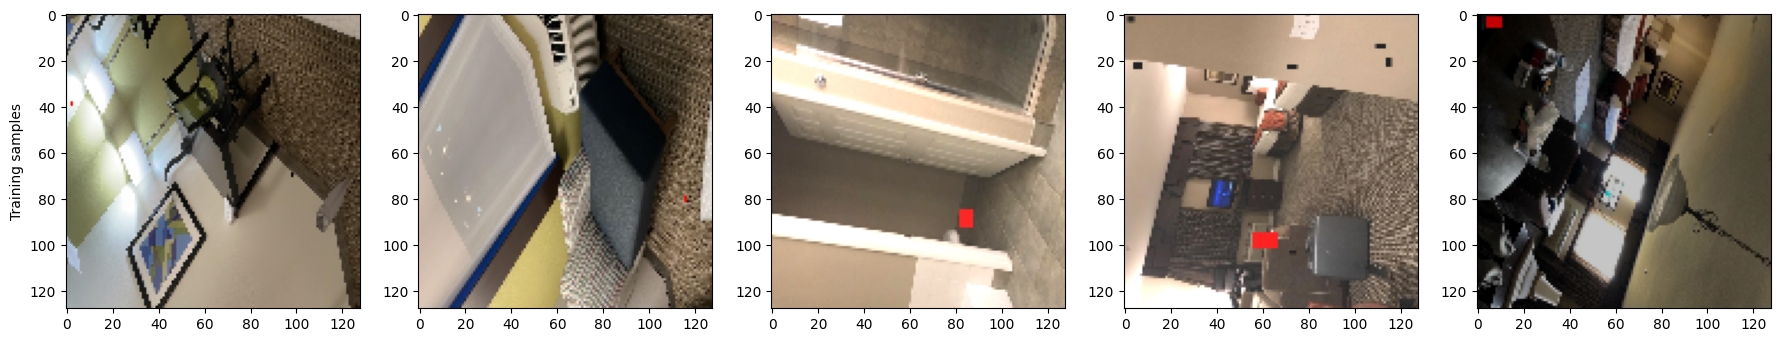

In [30]:
show_images(hotel_train, 'Training samples')

Altri cinque campioni sono invece mostrati dal set di validazione.

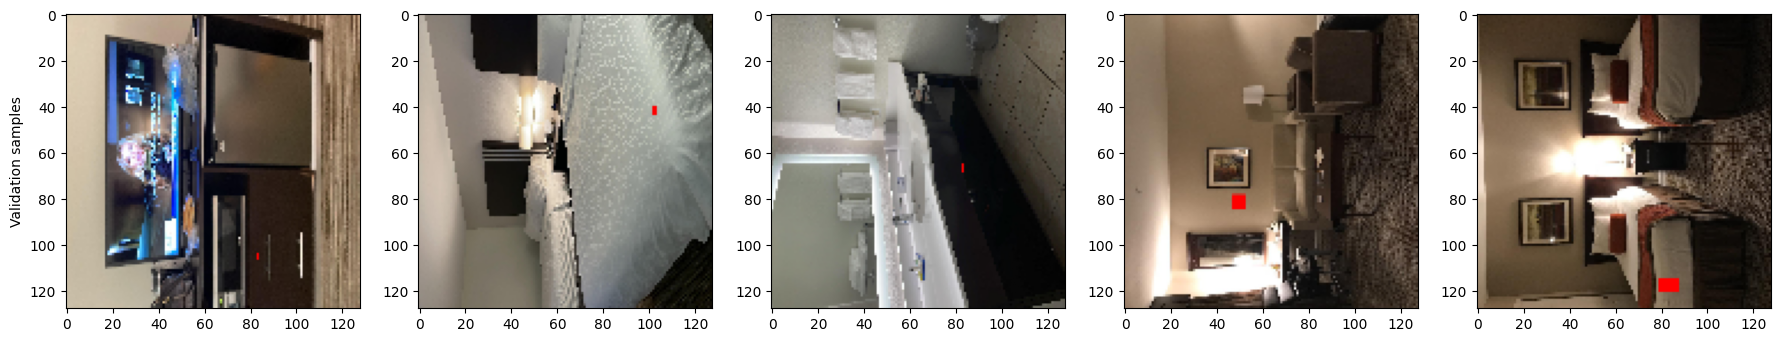

In [31]:
show_images(hotel_val, 'Validation samples')

### `PairedHotelDataset`

In [ ]:
pair_hotel_train = PairHotelDataset(df_train, train_transform, train_path)
pair_hotel_val = PairHotelDataset(df_val, val_transform, val_path)

pair_hotel_train_loader = DataLoader(pair_hotel_train, batch_size=64, num_workers=8, shuffle=True)
pair_hotel_val_loader = DataLoader(pair_hotel_val, batch_size=64, num_workers=8)

Si mostrano cinque coppie dal set di training (per ogni colonna si ha in alto il primo elemento della coppia, in basso il secondo elemento).

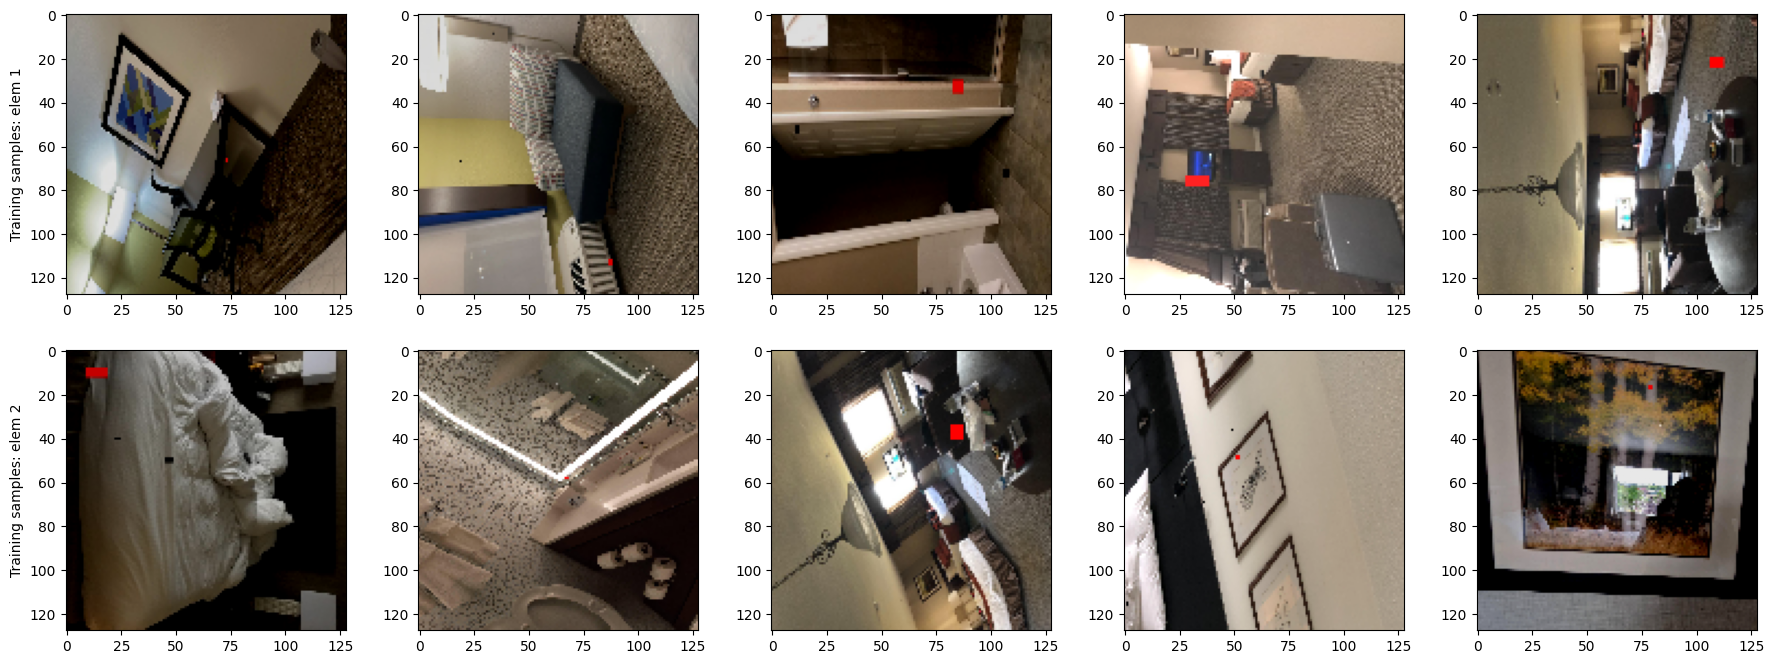

In [68]:
show_pair_images(pair_hotel_train, 'Training samples')

Di seguito altre cinque coppie dal set di validazione.

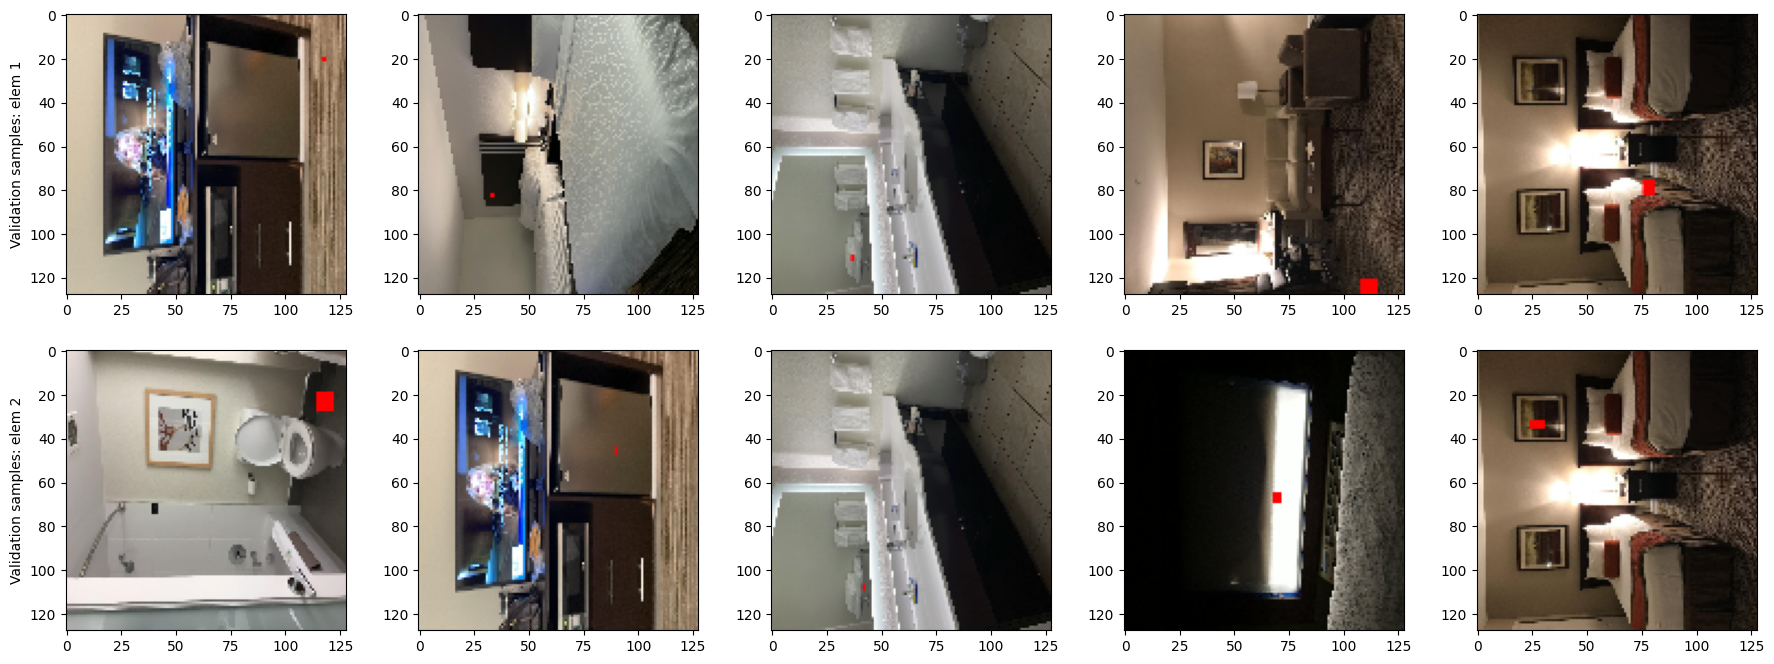

In [69]:
show_pair_images(pair_hotel_val, 'Validation samples')

## 3.1 - Controllo di validazione su `EfficientNet-B0`

Essendo una rete pre-addestrata, si vuole verificare il comportamento di `EfficientNet-B0` sui dati senza alcun addestramento.

In [10]:
n_classes_train = df_train['hotel_id'].max()
n_classes_val = df_val['hotel_id'].max()

n_classes = max(n_classes_train, n_classes_val) + 1

efficient_net = EfficientNet(n_classes)
logger = TensorBoardLogger("classification_logs", name="efficientnet_hotel_id")
trainer = pl.Trainer(accelerator='gpu', devices=1, logger=logger, max_epochs=5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


La seguente cella può essere utilizzata per eseguire una validazione.

In [20]:
trainer.validate(efficient_net, hotel_val_loader)

Missing logger folder: classification_logs/efficientnet_hotel_id
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 140/140 [05:34<00:00,  2.39s/it]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val/accuracy                  0.0
        val/loss            13.445038795471191
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val/loss': 13.445038795471191, 'val/accuracy': 0.0}]

In [1]:
%load_ext tensorboard
%tensorboard --logdir classification_logs/efficientnet_hotel_id

## 3.2 - Training classificatore `HotelPredictionNetworkv1`

Vengono istanziate la rete siamese e relativi logger e trainer.

In [10]:
from pytorch_lightning.loggers import TensorBoardLogger

n_classes_train = df_train['hotel_id'].max()
n_classes_val = df_val['hotel_id'].max()

n_classes = max(n_classes_train, n_classes_val) + 1

model = HotelPredictionNetworkv1(n_classes=n_classes, embedding_size=128)
logger = TensorBoardLogger("classification_logs", name="siamese_hotel_id")
trainer = pl.Trainer(accelerator='gpu', devices=1, logger=logger, max_epochs=5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


La seguente cella può essere utilizzata per caricare la stessa rete mediante file di checkpoint precedentemente salvato su disco, ed eventualmente continuare un addestramento lasciato interrotto.

In [ ]:
from pytorch_lightning.loggers import TensorBoardLogger

n_classes_train = df_train['hotel_id'].max()
n_classes_val = df_val['hotel_id'].max()

n_classes = max(n_classes_train, n_classes_val) + 1

model = HotelPredictionNetwork.load_from_checkpoint('classification_logs/siamese_hotel_id/version_1/checkpoints/epoch=4-step=2795.ckpt', n_classes=n_classes, embedding_size=128)
logger = TensorBoardLogger("classification_logs", name="siamese_hotel_id")
trainer = pl.Trainer(accelerator='gpu', devices=1, logger=logger, max_epochs=5)

Mediante la seguente cella viene eseguito l'addestramento del classificatore.

In [11]:
trainer.fit(model, hotel_train_loader, hotel_val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type             | Params
------------------------------------------------
0 | extractor  | EfficientNet     | 4.0 M 
1 | embedding  | Linear           | 163 K 
2 | classifier | Linear           | 89.1 M
3 | criterion  | CrossEntropyLoss | 0     
------------------------------------------------
93.2 M    Trainable params
0         Non-trainable params
93.2 M    Total params
372.915   Total estimated model params size (MB)


Epoch 4: 100%|██████████| 699/699 [36:58<00:00,  3.17s/it, loss=5.81, v_num=2] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 699/699 [36:59<00:00,  3.18s/it, loss=5.81, v_num=2]


Mediante la seguente cella viene invece eseguita la sua validazione.

In [12]:
trainer.validate(model, hotel_val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 140/140 [06:56<00:00,  2.97s/it]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val/accuracy         0.013645006151437199
        val/loss             8.215980529785156
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val/loss': 8.215980529785156, 'val/accuracy': 0.013645006151437199}]

In [6]:
%load_ext tensorboard
%tensorboard --logdir classification_logs/siamese_hotel_id

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6008 (pid 6284), started 0:00:05 ago. (Use '!kill 6284' to kill it.)

## 3.3 - Training `HotelPredictionNetworkv2`

Vengono istanziate la rete siamese e relativi logger e trainer.

In [ ]:
from pytorch_lightning.loggers import TensorBoardLogger

siamese_hotel_task = HotelPredictionNetworkv2()
logger = TensorBoardLogger("metric_logs", name="siamese_hotel_id")
trainer = pl.Trainer(accelerator='gpu', devices=1, logger=logger, max_epochs=5)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


La seguente cella può essere utilizzata per caricare la stessa rete mediante file di checkpoint precedentemente salvato su disco, ed eventualmente continuare un addestramento lasciato interrotto.

In [7]:
from pytorch_lightning.loggers import TensorBoardLogger

siamese_hotel_task = HotelPredictionNetworkv2.load_from_checkpoint('metric_logs/siamese_hotel_id/version_0/checkpoints/epoch=4-step=2795.ckpt')
logger = TensorBoardLogger("metric_logs", name="siamese_hotel_id")
trainer = pl.Trainer(accelerator='gpu', devices=1, logger=logger, max_epochs=5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Mediante la seguente cella si addestra la rete siamese.

In [ ]:
trainer.fit(siamese_hotel_task, pair_hotel_train_loader, pair_hotel_val_loader)

Missing logger folder: metric_logs/siamese_hotel_id
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type            | Params
----------------------------------------------
0 | embedding | EfficientNet    | 4.0 M 
1 | criterion | ContrastiveLoss | 0     
----------------------------------------------
4.0 M     Trainable params
0         Non-trainable params
4.0 M     Total params
16.030    Total estimated model params size (MB)


Epoch 4: 100%|██████████| 699/699 [57:44<00:00,  4.96s/it, loss=0.481, v_num=0]  

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 699/699 [57:44<00:00,  4.96s/it, loss=0.481, v_num=0]


Mediante la seguente cella si effettua la validazione del modello.

In [ ]:
trainer.validate(siamese_hotel_task, pair_hotel_val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 140/140 [05:21<00:00,  2.30s/it]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val/loss            0.40283799171447754
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val/loss': 0.40283799171447754}]

In [ ]:
%load_ext tensorboard
%tensorboard --logdir metric_logs/siamese_hotel_id

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 20546), started 0:00:04 ago. (Use '!kill 20546' to kill it.)

### 3.2.1 - Salvataggio degli embeddings su disco

Viene anzitutto definita una funzione `extract_representations(model, loader)` che preso un modello e un dataloader, restituisce le nuove rappresentazioni dei dati presenti nel dataloader `loader` e computate dal modello `model`.

In [18]:
def extract_representations(model, loader):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.eval()
    model.to(device)
    representations, labels = [], []

    for batch in loader:
        x = batch[0].to(device)
        rep = model(x)
        rep = rep.detach().to('cpu').numpy()
        labels.append(batch[1])
        representations.append(rep)

    return np.concatenate(representations), np.concatenate(labels)


Vengono estratte le rappresentazioni del dataset di training (a singolo output, poiché il paired dataset è necessario esclusivamente all'addestramento del modello di metric learning con loss contrastive).

In [19]:
hotel_train = HotelDataset(df_train, train_transform, train_path)
hotel_train_loader = DataLoader(hotel_train, batch_size=64, num_workers=8)

representations, labels = extract_representations(siamese_hotel_task, hotel_train_loader)

Vengono inserite le rappresentazioni sotto una nuova colonna `representation` del dataframe di training originario (inizialmente caricato da `csv`).

In [20]:
df_train_w_repr = df_train
df_train_w_repr['representation'] = list(representations)
df_train_w_repr.head()

image_id  hotel_id                                     representation
0  000003767.jpg    100055  [-0.23942466, -0.20735869, -0.22223592, -0.208...
1  000003768.jpg    100055  [-0.23135966, -0.19363037, -0.20756839, -0.190...
2  000019601.jpg     10010  [-0.22385257, -0.19876081, -0.21029243, -0.202...
3  000019602.jpg     10010  [-0.21756901, -0.19270661, -0.202687, -0.19265...
4  000019605.jpg     10010  [-0.23554295, -0.2028898, -0.21720469, -0.2073...

Viene quindi salvato il dataframe ottenuto su disco.\
Esso verrà utilizzato nel corso dell'inferenza.

In [21]:
df_train_w_repr.to_pickle(os.path.join(dataset_path, 'train_image-embeddings.pkl'))

## 3.4 Training `HotelPredictionNetworkv3`

Vengono istanziate la rete e relativi logger e trainer.

In [12]:
from pytorch_lightning.loggers import TensorBoardLogger

n_classes_train = df_train['hotel_id'].max()
n_classes_val = df_val['hotel_id'].max()

n_classes = max(n_classes_train, n_classes_val) + 1

siamesewclass_hotel_task = HotelPredictionNetworkv3(n_classes, 128)
logger = TensorBoardLogger("classification_logs", name="siamesewclass_hotel_id")
trainer = pl.Trainer(accelerator='gpu', devices=1, logger=logger, max_epochs=5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


La seguente cella può essere utilizzata per caricare la stessa rete mediante file di checkpoint precedentemente salvato su disco, ed eventualmente continuare un addestramento lasciato interrotto.

In [ ]:
from pytorch_lightning.loggers import TensorBoardLogger

n_classes_train = df_train['hotel_id'].max()
n_classes_val = df_val['hotel_id'].max()

n_classes = max(n_classes_train, n_classes_val) + 1

siamesewclass_hotel_task = HotelPredictionNetworkv3.load_from_checkpoint('classification_logs/siamesewclass_hotel_id/version_0/checkpoints/epoch=4-step=2795.ckpt', n_classes=n_classes, embedding_size=128)
logger = TensorBoardLogger("classification_logs", name="siamesewclass_hotel_id")
trainer = pl.Trainer(accelerator='gpu', devices=1, logger=logger, max_epochs=5)

Mediante la seguente cella si addestra la rete.

In [13]:
trainer.fit(siamesewclass_hotel_task, hotel_train_loader, hotel_val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type                     | Params
--------------------------------------------------------
0 | backbone   | HotelPredictionNetworkv2 | 4.0 M 
1 | embedding  | Linear                   | 163 K 
2 | classifier | Linear                   | 89.1 M
3 | criterion  | CrossEntropyLoss         | 0     
--------------------------------------------------------
93.2 M    Trainable params
0         Non-trainable params
93.2 M    Total params
372.915   Total estimated model params size (MB)


Epoch 4: 100%|██████████| 699/699 [24:51<00:00,  2.13s/it, loss=6.98, v_num=1] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 699/699 [24:52<00:00,  2.14s/it, loss=6.98, v_num=1]


In [14]:
trainer.validate(siamesewclass_hotel_task, hotel_val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 140/140 [05:11<00:00,  2.22s/it]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      val/accuracy         0.002796107817917459
        val/loss             8.842184066772461
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val/loss': 8.842184066772461, 'val/accuracy': 0.002796107817917459}]

In [4]:
%load_ext tensorboard
%tensorboard --logdir classification_logs/siamesewclass_hotel_id

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 5996), started 0:00:10 ago. (Use '!kill 5996' to kill it.)